# Aspect-Based Sentiment Analysis với DistilBERT + LSTM

Model kết hợp DistilBERT và LSTM để phân loại sentiment (positive, negative, neutral) với AspectTerm làm thông tin bổ trợ trong quá trình training.

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-11-26 02:47:37.837529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764125258.079157      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764125258.143364      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [2]:
# Đọc dữ liệu
csv_file = '/kaggle/input/serviceandelectronics/merged_dataset_balanced.csv'
print(f"Đang đọc file {csv_file}...")

df = pd.read_csv(csv_file)

print(f"\n✓ Đã đọc {len(df):,} dòng dữ liệu")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nDữ liệu mẫu:")
df.head()

Đang đọc file /kaggle/input/serviceandelectronics/merged_dataset_balanced.csv...

✓ Đã đọc 5,388 dòng dữ liệu

Các cột: ['reviewText', 'AspectTerm', 'Sentiment']

Dữ liệu mẫu:


,reviewText,AspectTerm,Sentiment
0,I would have given these bars two stars since ...,food general,negative
1,The rooms in the main building are to standard...,rooms design_features,neutral
2,I purchased this in hopes of using it with my ...,sound,neutral
3,"Fantastic hotel , fantastic city Planned a fou...",hotel general,positive
4,Love this flavor .,food quality,positive


In [3]:
# Tiền xử lý dữ liệu
print("Thống kê sentiment:")
print(df['Sentiment'].value_counts())

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print(f"\nMapping labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

# Xử lý missing values
df = df.dropna(subset=['reviewText', 'AspectTerm', 'Sentiment'])

print(f"\nSố dòng sau khi xử lý: {len(df):,}")

Thống kê sentiment:
Sentiment
negative    1800
positive    1800
neutral     1788
Name: count, dtype: int64

Mapping labels:
  negative: 0
  neutral: 1
  positive: 2

Số dòng sau khi xử lý: 5,388


In [4]:
# Chia dữ liệu train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

print(f"\nTrain distribution:")
print(train_df['Sentiment'].value_counts())
print(f"\nTest distribution:")
print(test_df['Sentiment'].value_counts())
print(f"\nVal distribution:")
print(val_df['Sentiment'].value_counts())

Train set: 3,771 samples
Validation set: 808 samples
Test set: 809 samples

Train distribution:
Sentiment
negative    1260
positive    1260
neutral     1251
Name: count, dtype: int64

Test distribution:
Sentiment
negative    270
positive    270
neutral     269
Name: count, dtype: int64

Val distribution:
Sentiment
positive    270
negative    270
neutral     268
Name: count, dtype: int64


In [5]:
# Custom Dataset class
class AspectSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        review = str(self.data.loc[idx, 'reviewText'])
        aspect = str(self.data.loc[idx, 'AspectTerm'])
        label = self.data.loc[idx, 'label']
        
        # Kết hợp review và aspect: "[CLS] review [SEP] aspect [SEP]"
        combined_text = review + " [SEP] " + aspect
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("✓ Tokenizer loaded")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✓ Tokenizer loaded


In [6]:
# Tạo DataLoader
BATCH_SIZE = 16
MAX_LEN = 128

train_dataset = AspectSentimentDataset(train_df, tokenizer, MAX_LEN)
val_dataset = AspectSentimentDataset(val_df, tokenizer, MAX_LEN)
test_dataset = AspectSentimentDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ DataLoaders created
  Train batches: 236
  Val batches: 51
  Test batches: 51


In [7]:
# Model: DistilBERT + LSTM
class DistilBertLSTMClassifier(nn.Module):
    def __init__(self, n_classes=3, lstm_hidden_size=128, lstm_layers=2, dropout=0.3):
        super(DistilBertLSTMClassifier, self).__init__()
        
        # DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=768,  # DistilBERT hidden size
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classifier
        self.fc = nn.Linear(lstm_hidden_size * 2, n_classes)  # *2 for bidirectional
        
    def forward(self, input_ids, attention_mask):
        # DistilBERT embeddings
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # last_hidden_state: [batch_size, seq_len, 768]
        sequence_output = distilbert_output.last_hidden_state
        
        # LSTM
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        
        # Lấy output từ hidden state cuối cùng của cả 2 directions
        # hidden: [num_layers * 2, batch_size, hidden_size]
        # Lấy layer cuối: [-2:] -> [2, batch_size, hidden_size]
        hidden_fwd = hidden[-2, :, :]  # forward direction
        hidden_bwd = hidden[-1, :, :]  # backward direction
        
        # Concatenate
        hidden_concat = torch.cat((hidden_fwd, hidden_bwd), dim=1)
        
        # Dropout
        hidden_concat = self.dropout(hidden_concat)
        
        # Classifier
        output = self.fc(hidden_concat)
        
        return output

# Khởi tạo model
model = DistilBertLSTMClassifier(n_classes=3)
model = model.to(device)

print("✓ Model created")
print(f"\nModel architecture:")
print(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✓ Model created

Model architecture:
DistilBertLSTMClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Drop

In [8]:
# Training configuration
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

EPOCHS = 10
LEARNING_RATE = 2e-5

# Loss function và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Device: {device}")

Training configuration:
  Epochs: 10
  Learning rate: 2e-05
  Batch size: 16
  Device: cuda


In [9]:
# Training functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

print("✓ Training functions defined")

✓ Training functions defined


In [10]:
# Training loop
import time

print("=" * 80)
print("TRAINING START")
print("=" * 80)

best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  ✓ Best model saved!")
    
    elapsed = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} - {elapsed:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-" * 80)

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("=" * 80)

TRAINING START
  ✓ Best model saved!

Epoch 1/10 - 31.87s
  Train Loss: 0.7184 | Train Acc: 0.7353
  Val Loss: 0.5034 | Val Acc: 0.8193
--------------------------------------------------------------------------------
  ✓ Best model saved!

Epoch 2/10 - 31.20s
  Train Loss: 0.4447 | Train Acc: 0.8390
  Val Loss: 0.4725 | Val Acc: 0.8379
--------------------------------------------------------------------------------

Epoch 3/10 - 30.61s
  Train Loss: 0.3288 | Train Acc: 0.8876
  Val Loss: 0.5093 | Val Acc: 0.8292
--------------------------------------------------------------------------------

Epoch 4/10 - 30.62s
  Train Loss: 0.2525 | Train Acc: 0.9218
  Val Loss: 0.5476 | Val Acc: 0.8292
--------------------------------------------------------------------------------

Epoch 5/10 - 30.64s
  Train Loss: 0.1854 | Train Acc: 0.9419
  Val Loss: 0.6027 | Val Acc: 0.8156
--------------------------------------------------------------------------------

Epoch 6/10 - 30.64s
  Train Loss: 0.1626

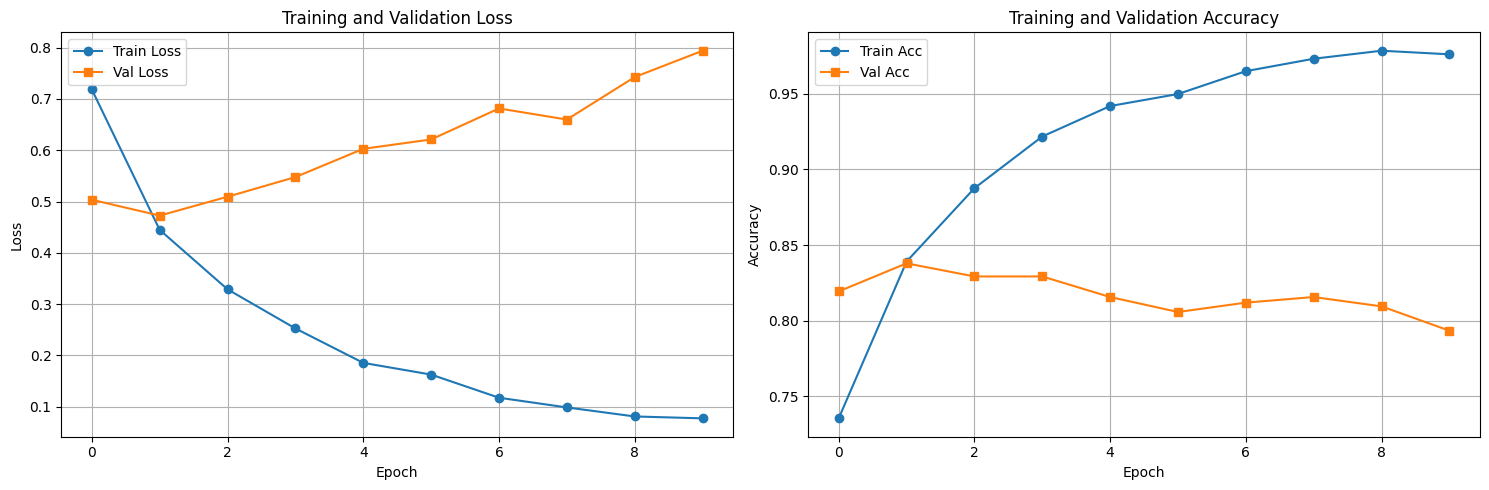

In [11]:
# Visualize training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Evaluate on test set
print("=" * 80)
print("EVALUATING ON TEST SET")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=label_encoder.classes_,
    digits=4
))

EVALUATING ON TEST SET

Test Loss: 0.4281
Test Accuracy: 0.8430

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.7934    0.8963    0.8417       270
     neutral     0.9256    0.7398    0.8223       269
    positive     0.8339    0.8926    0.8623       270

    accuracy                         0.8430       809
   macro avg     0.8510    0.8429    0.8421       809
weighted avg     0.8509    0.8430    0.8421       809



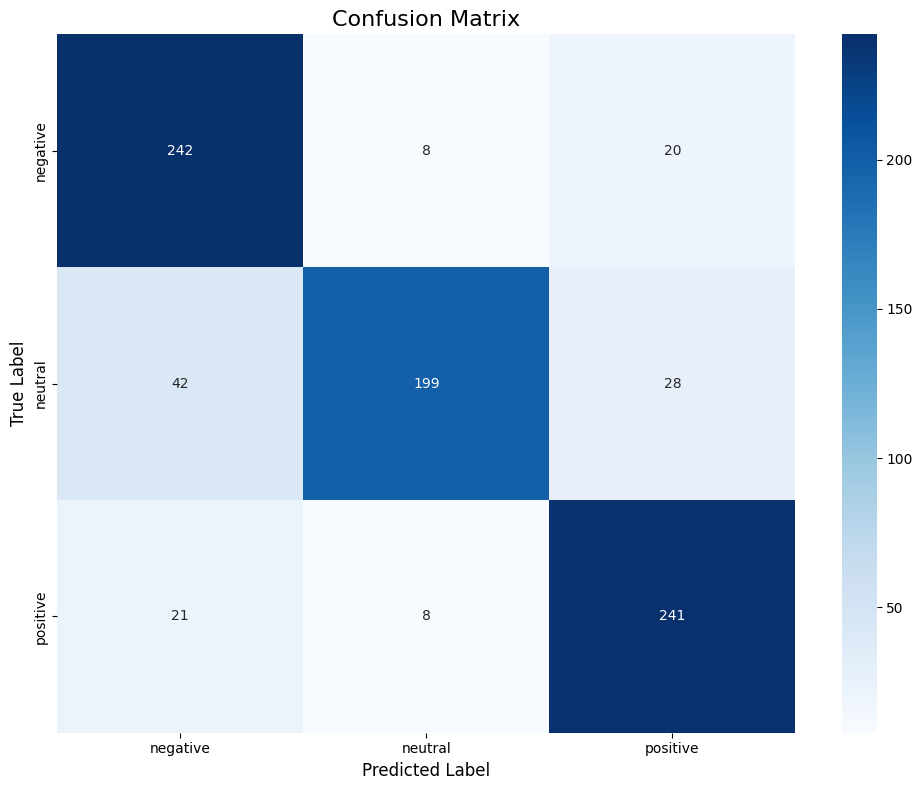

In [13]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
# Prediction function
def predict_sentiment(review_text, aspect_term, model, tokenizer, device, label_encoder, max_len=128):
    """
    Dự đoán sentiment cho một review và aspect term
    
    Args:
        review_text: Văn bản review
        aspect_term: Khía cạnh cần đánh giá
        model: Model đã train
        tokenizer: DistilBERT tokenizer
        device: CPU hoặc CUDA
        label_encoder: LabelEncoder đã fit
        max_len: Độ dài tối đa của sequence
    
    Returns:
        Sentiment predicted (positive/negative/neutral) và probability
    """
    model.eval()
    
    # Kết hợp review và aspect
    combined_text = review_text + " [SEP] " + aspect_term
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, confidence, probabilities[0].cpu().numpy()

print("✓ Prediction function defined")

✓ Prediction function defined


In [15]:
# Test prediction với ví dụ cụ thể
print("=" * 80)
print("TESTING PREDICTIONS")
print("=" * 80)

# Ví dụ 1
review1 = "The food was absolutely amazing and the service was great"
aspect1 = "food quality"
pred1, conf1, probs1 = predict_sentiment(review1, aspect1, model, tokenizer, device, label_encoder)
print(f"\nExample 1:")
print(f"  Review: {review1}")
print(f"  Aspect: {aspect1}")
print(f"  Predicted: {pred1} (confidence: {conf1:.4f})")
print(f"  Probabilities: negative={probs1[0]:.4f}, neutral={probs1[1]:.4f}, positive={probs1[2]:.4f}")

# Ví dụ 2
review2 = "The product quality is poor and it broke after one day"
aspect2 = "food quality"
pred2, conf2, probs2 = predict_sentiment(review2, aspect2, model, tokenizer, device, label_encoder)
print(f"\nExample 2:")
print(f"  Review: {review2}")
print(f"  Aspect: {aspect2}")
print(f"  Predicted: {pred2} (confidence: {conf2:.4f})")
print(f"  Probabilities: negative={probs2[0]:.4f}, neutral={probs2[1]:.4f}, positive={probs2[2]:.4f}")

# Ví dụ 3
review3 = "It's okay, nothing special but works as expected"
aspect3 = "food general"
pred3, conf3, probs3 = predict_sentiment(review3, aspect3, model, tokenizer, device, label_encoder)
print(f"\nExample 3:")
print(f"  Review: {review3}")
print(f"  Aspect: {aspect3}")
print(f"  Predicted: {pred3} (confidence: {conf3:.4f})")
print(f"  Probabilities: negative={probs3[0]:.4f}, neutral={probs3[1]:.4f}, positive={probs3[2]:.4f}")

TESTING PREDICTIONS

Example 1:
  Review: The food was absolutely amazing and the service was great
  Aspect: food quality
  Predicted: positive (confidence: 0.9446)
  Probabilities: negative=0.0256, neutral=0.0298, positive=0.9446

Example 2:
  Review: The product quality is poor and it broke after one day
  Aspect: food quality
  Predicted: negative (confidence: 0.9171)
  Probabilities: negative=0.9171, neutral=0.0486, positive=0.0343

Example 3:
  Review: It's okay, nothing special but works as expected
  Aspect: food general
  Predicted: neutral (confidence: 0.9688)
  Probabilities: negative=0.0155, neutral=0.9688, positive=0.0156


In [16]:
# Save model và các components
print("\n" + "=" * 80)
print("SAVING MODEL")
print("=" * 80)

# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'max_len': MAX_LEN,
    'history': history
}, 'distilbert_lstm_model_complete.pt')

print("✓ Model saved to: distilbert_lstm_model_complete.pt")

# Model summary
print("\n" + "=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
print(f"Architecture: DistilBERT + Bi-LSTM")
print(f"Number of classes: 3 (negative, neutral, positive)")
print(f"DistilBERT hidden size: 768")
print(f"LSTM hidden size: 128")
print(f"LSTM layers: 2 (bidirectional)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


SAVING MODEL
✓ Model saved to: distilbert_lstm_model_complete.pt

MODEL SUMMARY
Architecture: DistilBERT + Bi-LSTM
Number of classes: 3 (negative, neutral, positive)
DistilBERT hidden size: 768
LSTM hidden size: 128
LSTM layers: 2 (bidirectional)
Total parameters: 67,678,467
Trainable parameters: 67,678,467

Best Validation Accuracy: 0.8379
Test Accuracy: 0.8430
